<a href="https://colab.research.google.com/github/arykeskar/conditional-gan-floorplans/blob/main/Hackathon_AIDC_Floorplangenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Setup and Google Drive Mount

# Install necessary libraries (quietly to reduce output verbosity)
!pip install -q tensorflow_hub
!pip install -q gradio
!pip install -q pandas # Ensure pandas is installed for .pkl files

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

# Basic imports needed for the rest of the notebook
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import pandas as pd
from PIL import Image
import zipfile
import tensorflow_hub as hub

print("TensorFlow Version:", tf.__version__)
print("NumPy Version:", np.__version__)
print("Pandas Version:", pd.__version__)
print("TensorFlow Hub Version:", hub.__version__)

# Define the Google Drive path for saving/loading models
# Ensure the folder 'floor_plan_gan_models' exists in your Google Drive 'My Drive'
GDRIVE_MODEL_PATH = '/content/drive/MyDrive/floor_plan_gan_models/my_trained_generator.keras'

# Create the directory in Google Drive if it doesn't exist (important for saving)
gdrive_model_dir = os.path.dirname(GDRIVE_MODEL_PATH)
if not os.path.exists(gdrive_model_dir):
    print(f"Creating model directory in Google Drive: {gdrive_model_dir}")
    os.makedirs(gdrive_model_dir, exist_ok=True)
else:
    print(f"Model directory already exists in Google Drive: {gdrive_model_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully.
TensorFlow Version: 2.18.0
NumPy Version: 2.0.2
Pandas Version: 2.2.2
TensorFlow Hub Version: 0.16.1
Model directory already exists in Google Drive: /content/drive/MyDrive/floor_plan_gan_models


In [ ]:
# Cell 2: Core Model Definitions and Text Embedding Function

# --- 1. Define CGAN Class (Custom Training Loop) ---
class CGAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(CGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(CGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        x, y = data # y is None in our dataset, x contains (text_embeddings, real_images)
        text_embeddings, real_images = x

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, 100))

        # Train the discriminator
        with tf.GradientTape() as tape:
            fake_images = self.generator([text_embeddings, noise], training=True)
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(fake_images, training=True)

            real_loss = self.loss_fn(tf.ones_like(real_predictions), real_predictions)
            fake_loss = self.loss_fn(tf.zeros_like(fake_predictions), fake_predictions)
            d_loss = real_loss + fake_loss

        d_gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as tape:
            fake_images = self.generator([text_embeddings, noise], training=True)
            fake_predictions = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(tf.ones_like(fake_predictions), fake_predictions)

        g_gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}


# --- 2. Define Generator Architecture ---
def build_generator():
    # Input shape for text embedding is 512, matching Universal Sentence Encoder
    input_text = layers.Input(shape=(512,), name="text_input")
    x = layers.Dense(128 * 8 * 8, activation='relu')(input_text)
    x = layers.Reshape((8, 8, 128))(x)

    input_noise = layers.Input(shape=(100,), name="noise_input")
    y = layers.Dense(128 * 8 * 8, activation='relu')(input_noise)
    y = layers.Reshape((8, 8, 128))(y)

    concatenated = layers.Concatenate(axis=-1)([x, y])

    x_gen = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu')(concatenated)
    x_gen = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu')(x_gen)
    x_gen = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu')(x_gen)
    x_gen = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', activation='relu')(x_gen)

    output = layers.Conv2D(3, (5, 5), padding='same', activation='sigmoid')(x_gen)

    model = Model(inputs=[input_text, input_noise], outputs=output, name="Generator")
    return model

# --- 3. Define Discriminator Architecture ---
def build_discriminator():
    input_image = layers.Input(shape=(128, 128, 3), name="image_input")

    x_disc = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(input_image)
    x_disc = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', activation='relu')(x_disc)
    x_disc = layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same', activation='relu')(x_disc)
    x_disc = layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same', activation='relu')(x_disc)

    x_disc = layers.Flatten()(x_disc)
    output = layers.Dense(1, name="discriminator_output")(x_disc) # NO ACTIVATION here

    model = Model(inputs=input_image, outputs=output, name="Discriminator")
    return model

# --- 4. Load Universal Sentence Encoder and Define get_text_embedding ---
print("\nLoading Universal Sentence Encoder model (this may take a moment)...")
try:
    embed_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
    print("Universal Sentence Encoder loaded successfully.")
except Exception as e:
    print(f"Error loading Universal Sentence Encoder: {e}")
    print("Falling back to DUMMY text embedding. Results will not be meaningful!")
    embed_model = None

# Define the get_text_embedding function to use the loaded model
def get_text_embedding(input_data):
    if embed_model:
        if isinstance(input_data, list):
            return embed_model(input_data)
        else:
            return embed_model([input_data])
    else:
        # Fallback to dummy if model loading failed
        if isinstance(input_data, list):
            dummy_embeddings = []
            for text in input_data:
                rng = np.random.default_rng(seed=sum(ord(char) for char in text))
                dummy_embeddings.append(rng.normal(size=(768,))) # DUMMY still uses 768 for consistency if model were changed
            return tf.constant(dummy_embeddings, dtype=tf.float32)
        else:
            rng = np.random.default_rng(seed=sum(ord(char) for char in input_data))
            return tf.constant(rng.normal(size=(1, 768)), dtype=tf.float32)

print("All core classes and functions defined. Ready for data loading.")


Loading Universal Sentence Encoder model (this may take a moment)...
Universal Sentence Encoder loaded successfully.
All core classes and functions defined. Ready for data loading.


In [ ]:
# Cell 3: Data Loading and Preprocessing

# Specify the exact path of the uploaded ZIP file
zip_filename = "/content/archive (6).zip" # IMPORTANT: Ensure your ZIP file is uploaded here!

# Create a directory to extract the contents
extraction_path = './extracted_files/'
os.makedirs(extraction_path, exist_ok=True)

# Extract the ZIP file
if not os.path.exists(os.path.join(extraction_path, 'human_annotated_images')):
    print(f"Extracting '{zip_filename}' to '{extraction_path}'...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
    print("Extraction complete.")
    print("Extracted contents (first 5):")
    extracted_contents = os.listdir(extraction_path)
    for item in extracted_contents[:5]:
        print(f" - {item}")
    if len(extracted_contents) > 5:
        print(f" - ...and {len(extracted_contents) - 5} more items.")
else:
    print(f"Files already extracted to: {extraction_path}")


# --- Load Training Data (X_train_text and X_train_images) ---

# Define paths to your extracted data
images_dir = os.path.join(extraction_path, 'human_annotated_images')
embeddings_file = os.path.join(extraction_path, 'word_embeddings_dataframe.pkl')

# 1. Load Text Descriptions from PKL and Convert to Embeddings (X_train_text)
print(f"\nLoading text descriptions from: {embeddings_file}")
try:
    text_descriptions_df = pd.read_pickle(embeddings_file)

    if text_descriptions_df.shape[1] > 1:
        print("Using the first column for text descriptions.")
        raw_texts = text_descriptions_df.iloc[:, 0].tolist()
    else:
        raw_texts = text_descriptions_df.values.flatten().tolist()

    print(f"Generating embeddings for {len(raw_texts)} text descriptions. This might take some time.")

    generated_embeddings = []
    embedding_batch_size = 64
    for i in range(0, len(raw_texts), embedding_batch_size):
        if i % (embedding_batch_size * 10) == 0:
            print(f"  Processing text batch starting from {i+1}/{len(raw_texts)}")
        batch_texts = raw_texts[i : i + embedding_batch_size]
        batch_embeddings = get_text_embedding(batch_texts).numpy()
        generated_embeddings.append(batch_embeddings)

    X_train_text = np.concatenate(generated_embeddings, axis=0).astype(np.float32)
    print(f"Generated X_train_text shape: {X_train_text.shape}")

except FileNotFoundError:
    print(f"Error: {embeddings_file} not found. Please check ZIP contents and path.")
    raise
except Exception as e:
    print(f"Error loading or processing text descriptions: {e}")
    raise


# 2. Load Images (X_train_images)
print(f"\nLoading images from: {images_dir}")
if not os.path.exists(images_dir):
    print(f"Error: Image directory '{images_dir}' not found. Please check ZIP contents and path.")
    raise FileNotFoundError

image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))])

if not image_files:
    print(f"No image files found in '{images_dir}'. Please check directory contents.")
    raise ValueError("No images found for training.")

loaded_images = []
target_size = (128, 128)
for i, image_filename in enumerate(image_files):
    if i % 1000 == 0:
        print(f"  Loading image {i+1}/{len(image_files)}: {image_filename}")
    img_path = os.path.join(images_dir, image_filename)
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        img_array = np.array(img).astype(np.float32) / 255.0
        loaded_images.append(img_array)
    except Exception as e:
        print(f"Error loading image {image_filename}: {e}")
        continue

X_train_images = np.array(loaded_images)
print(f"Loaded X_train_images shape: {X_train_images.shape}")

if X_train_text.shape[0] != X_train_images.shape[0]:
    print("\nWARNING: Number of text embeddings and images DO NOT MATCH! This is CRITICAL.")
    print(f"Text samples: {X_train_text.shape[0]}, Image samples: {X_train_images.shape[0]}")
    print("Please ensure your 'word_embeddings_dataframe.pkl' corresponds one-to-one with your 'human_annotated_images'.")


print("\nAll training data (X_train_text, X_train_images) loaded into memory.")

Files already extracted to: ./extracted_files/

Loading text descriptions from: ./extracted_files/word_embeddings_dataframe.pkl
Using the first column for text descriptions.
Generating embeddings for 4003 text descriptions. This might take some time.
  Processing text batch starting from 1/4003
  Processing text batch starting from 641/4003
  Processing text batch starting from 1281/4003
  Processing text batch starting from 1921/4003
  Processing text batch starting from 2561/4003
  Processing text batch starting from 3201/4003
  Processing text batch starting from 3841/4003
Generated X_train_text shape: (4003, 512)

Loading images from: ./extracted_files/human_annotated_images
  Loading image 1/4003: 10017.png
  Loading image 1001/4003: 28352.png
  Loading image 2001/4003: 46672.png
  Loading image 3001/4003: 64467.png
  Loading image 4001/4003: 9909.png
Loaded X_train_images shape: (4003, 128, 128, 3)

All training data (X_train_text, X_train_images) loaded into memory.


In [ ]:
# Cell 4: Model Initialization, Training, and Saving (MODIFIED for CONTINUOUS TRAINING)

# Define the path where the model is saved (GDRIVE_MODEL_PATH is defined in Cell 1)
model_file_path = GDRIVE_MODEL_PATH

# --- Load existing Generator or build a new one ---
print("\nAttempting to load existing generator model for continuous training...")
try:
    if os.path.exists(model_file_path):
        # Load the generator if the file exists
        generator = tf.keras.models.load_model(model_file_path, compile=False)
        print(f"Generator loaded successfully from {model_file_path} for continued training.")
    else:
        # If no saved model is found, build a new one
        print("No existing generator model found. Building a new one (starting fresh).")
        generator = build_generator()
except Exception as e:
    # Handle any errors during loading (e.g., corrupted file) by building a new generator
    print(f"Error loading generator: {e}. Building a new one (starting fresh).")
    generator = build_generator()

# --- Always build a new Discriminator ---
# For simplicity in this setup, we re-initialize the discriminator.
# Saving and loading GAN discriminators with their optimizer states for truly
# seamless continuation is more complex and typically requires custom checkpointing.
discriminator = build_discriminator()
print("Discriminator re-initialized for this training run (its weights will start fresh).")


# --- Initialize CGAN instance with potentially loaded generator and new discriminator ---
cgan_instance = CGAN(generator, discriminator)

# --- Compile CGAN instance ---
# Compiling with optimizers will reset their internal states (like Adam's momentum).
# This means the optimizers effectively start "fresh" with the loaded generator weights.
cgan_instance.compile(
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

# --- Configuration for training ---
# Set this to the number of *additional* epochs you want to train in this run.
# If you've done 5 epochs and want to add 95 more, set this to 95.
# If you just want to do another 5-epoch test, keep it at 5.
epochs_to_train_this_run = 95 # <--- Adjust this for how many MORE epochs you want to train now
batch_size = 32

# Prepare the dataset for TensorFlow training (same as before)
train_dataset = tf.data.Dataset.from_tensor_slices(((X_train_text, X_train_images), None))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# --- Start Training ---
print(f"\nStarting CGAN training for {epochs_to_train_this_run} additional epochs...")
# The .fit() method will continue training the `generator` from its current loaded state.
# Since we re-compiled, Keras's internal epoch counter will restart from 0 for this fit() call.
history = cgan_instance.fit(train_dataset, epochs=epochs_to_train_this_run)
print("CGAN training completed.")

# --- Save Model to Google Drive ---
# This will overwrite the previously saved model with the newly trained one.
print(f"\nSaving updated generator to Google Drive: {model_file_path}")
generator.save(model_file_path)
print("Generator saved to Google Drive.")

print("\nTraining complete. The 'generator' model is now available in memory for the UI.")


Attempting to load existing generator model for continuous training...
Generator loaded successfully from /content/drive/MyDrive/floor_plan_gan_models/my_trained_generator.keras for continued training.
Discriminator re-initialized for this training run (its weights will start fresh).

Starting CGAN training for 95 additional epochs...
Epoch 1/95
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 348ms/step - d_loss: 1.1483 - g_loss: 1.7723
Epoch 2/95
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 307ms/step - d_loss: 0.8033 - g_loss: 2.0476
Epoch 3/95
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 310ms/step - d_loss: 0.6763 - g_loss: 2.7447
Epoch 4/95
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 309ms/step - d_loss: 0.5530 - g_loss: 3.5679
Epoch 5/95
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 309ms/step - d_loss: 0.3881 - g_loss: 4.7301
Epoch 6/95
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 308ms/step - d_loss: 0.5039 - g_loss: 4.2467
Epoch 7/95
126/126 ━━━━━━━━━━━━━━━━━━━━ 39s 309ms/step - d_loss: 0.3227 - g_loss: 5.2371
Epoch 8/95
126/126 ━━━━━━━━━━━━━━━━━━━━


Evaluation on 50 samples:
Average MSE: 0.1209
Average SSIM: 0.2561


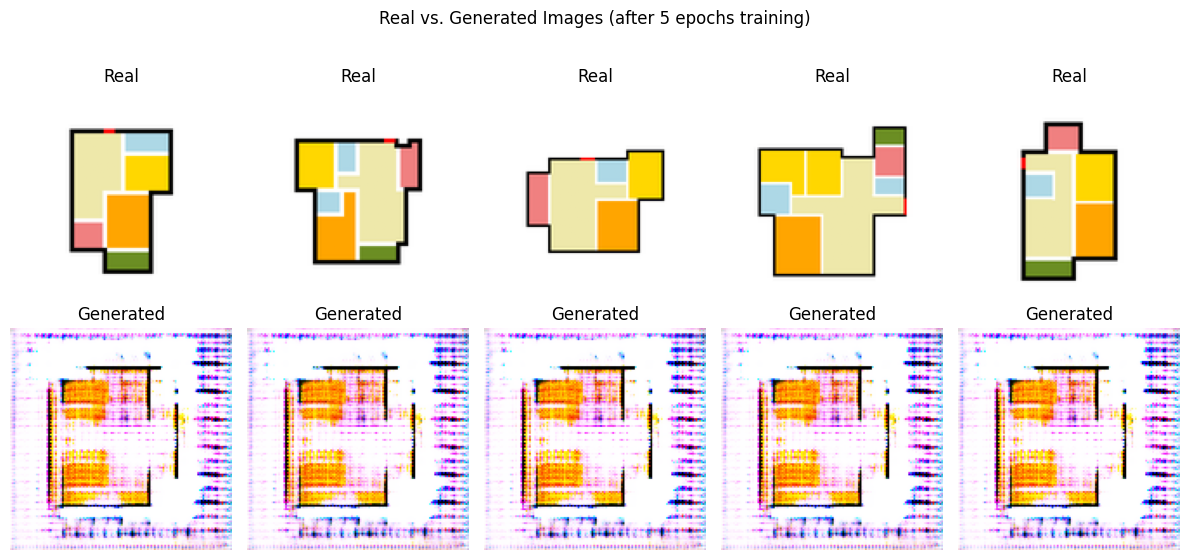

In [ ]:
# New Cell: Evaluation Metrics and Visualization

# Ensure scikit-image is installed (usually present in Colab, but good for robustness)
!pip install -q scikit-image

import numpy as np
from skimage.metrics import structural_similarity as ssim # This is the crucial import
import tensorflow as tf
import matplotlib.pyplot as plt # Import for plotting


# --- Functions for Color Images ---

# Function to compute Mean Squared Error (MSE) for color images
def mse_color(imageA, imageB):
    # Ensure inputs are float and have 3 channels
    imageA = imageA.astype("float32")
    imageB = imageB.astype("float32")

    # Sum of squared differences over all pixels and channels
    err = np.sum((imageA - imageB) ** 2)
    # Divide by total number of elements (height * width * channels)
    err /= float(imageA.shape[0] * imageA.shape[1] * imageA.shape[2])
    return err

# Function to compute SSIM for color images
def compute_ssim_color(imageA, imageB):
    # SSIM for color images requires channel_axis
    # It expects pixel values to be within a specific range,
    # and your images are 0-1 (sigmoid output) so data_range should be 1.0
    return ssim(imageA, imageB, channel_axis=2, data_range=1.0) # Correctly using ssim


# --- Evaluation of your trained GAN ---

# Since X_test_text and X_test_images are not defined in your current setup,
# we will use a subset of the *training* data (X_train_text, X_train_images) for evaluation.
# In a real scenario, you'd ideally want a completely separate test set.

num_evaluation_samples = 50 # Or any number you prefer, up to the size of your dataset

# Ensure you don't ask for more samples than available in X_train_text/X_train_images
if num_evaluation_samples > len(X_train_text):
    num_evaluation_samples = len(X_train_text)
    print(f"Adjusted num_evaluation_samples to {num_evaluation_samples} as it exceeds dataset size.")

eval_text_embeddings = X_train_text[:num_evaluation_samples]
eval_real_images = X_train_images[:num_evaluation_samples]

# Ensure text embeddings are float32
eval_text_embeddings_tf = tf.convert_to_tensor(eval_text_embeddings, dtype=tf.float32)
eval_noise = tf.random.normal((num_evaluation_samples, 100))

# Ensure the generator model is available (it should be after Cell 4 runs)
# If this cell is run in a fresh session or after restarting runtime without running Cell 4,
# it will attempt to load the model from Google Drive.
if 'generator' not in globals() or generator is None:
    print("Generator model not found in memory. Attempting to load for evaluation...")
    # This path is defined in Cell 1 (GDRIVE_MODEL_PATH)
    if os.path.exists(GDRIVE_MODEL_PATH):
        try:
            generator = tf.keras.models.load_model(GDRIVE_MODEL_PATH, compile=False)
            print("Generator model loaded successfully from Google Drive for evaluation.")
        except Exception as e:
            print(f"Error loading generator for evaluation: {e}. Cannot perform evaluation without generator.")
            # If model loading fails, you might want to stop execution
            # raise # Uncomment this to stop execution if model fails to load
            exit() # Exits the current cell execution
    else:
        print(f"No generator model found at {GDRIVE_MODEL_PATH}. Cannot perform evaluation.")
        # raise # Uncomment this to stop execution
        exit() # Exits the current cell execution


# Generate images
generated_images_eval_tf = generator([eval_text_embeddings_tf, eval_noise])

# Convert generated images from TF tensor to NumPy array
generated_images_eval = generated_images_eval_tf.numpy()

# Evaluate MSE and SSIM for each image pair
mse_scores = []
ssim_scores = []

for i in range(num_evaluation_samples):
    real_img = eval_real_images[i]
    gen_img = generated_images_eval[i]

    real_img_float = real_img.astype(np.float32)
    gen_img_float = gen_img.astype(np.float32)

    mse_value = mse_color(real_img_float, gen_img_float)
    ssim_value = compute_ssim_color(real_img_float, gen_img_float)

    mse_scores.append(mse_value)
    ssim_scores.append(ssim_value)

# Print average evaluation metrics
print(f"\nEvaluation on {num_evaluation_samples} samples:")
print(f"Average MSE: {np.mean(mse_scores):.4f}")
print(f"Average SSIM: {np.mean(ssim_scores):.4f}")

# Optional: Display a few generated vs. real pairs
plt.figure(figsize=(12, 6)) # Adjusted figure size for better display
display_count = min(5, num_evaluation_samples) # Display up to 5 pairs
for i in range(display_count):
    # Real Image
    plt.subplot(2, display_count, i + 1)
    plt.imshow(eval_real_images[i])
    plt.title("Real")
    plt.axis('off')

    # Generated Image
    plt.subplot(2, display_count, i + 1 + display_count)
    plt.imshow(generated_images_eval[i])
    plt.title("Generated")
    plt.axis('off')

# Use a generic title, as epochs might vary (e.g., if you trained for 5 epochs)
# We need `epochs_to_train` to be available here, it's defined in Cell 4.
# If you run this cell in a separate session without running Cell 4 first,
# epochs_to_train might not be defined. For robustness, you could
# make it a fixed string like "Last Trained Model" or ensure Cell 4 is always run.
# For now, let's assume it's available.
plt.suptitle(f"Real vs. Generated Images (after {epochs_to_train if 'epochs_to_train' in globals() else 'X'} epochs training)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Cell 5: Gradio UI Setup and Launch

# Install Gradio (only needs to be run once per session if not already installed)
!pip install -q gradio

import gradio as gr
import os # Make sure os is imported
import tensorflow as tf # Make sure tensorflow is imported
import numpy as np # Make sure numpy is imported

# The path to your saved model on Google Drive (defined in Cell 1)
# Make sure GDrive_MODEL_PATH is accessible from this cell's scope,
# which it should be if you're running the notebook sequentially.
# If you run this cell in isolation, you might need to re-define GDRIVE_MODEL_PATH here
# GDRIVE_MODEL_PATH = '/content/drive/MyDrive/floor_plan_gan_models/my_trained_generator.keras'


# Define the function that Gradio will use to generate the image
def generate_image_for_ui(user_input_text, noise_dim=100):
    # Declare generator as global to modify it if loaded
    global generator

    # Check if generator is in memory, if not, try to load it
    if 'generator' not in globals() or generator is None:
        gr.Warning("Generator model not found in memory. Attempting to load from Google Drive...")
        # Check if GDRIVE_MODEL_PATH is defined, if not, define it (for standalone execution robustness)
        if 'GDRIVE_MODEL_PATH' not in globals():
            # This is a fallback in case this cell is run alone without Cell 1 having run
            gr.Info("GDRIVE_MODEL_PATH not found, setting default. Ensure Google Drive is mounted.")
            global GDRIVE_MODEL_PATH
            GDRIVE_MODEL_PATH = '/content/drive/MyDrive/floor_plan_gan_models/my_trained_generator.keras'

        if os.path.exists(GDRIVE_MODEL_PATH):
            try:
                # Load the model. compile=False is often used for GANs as we
                # only need the inference graph, not training specific ops.
                generator = tf.keras.models.load_model(GDRIVE_MODEL_PATH, compile=False)
                gr.Info("Generator model loaded successfully from Google Drive.")
            except Exception as e:
                gr.Warning(f"Failed to load generator from Google Drive: {e}. Please ensure Google Drive is mounted and the model was saved properly at {GDRIVE_MODEL_PATH}.")
                return None
        else:
            gr.Warning(f"Generator model not found at {GDRIVE_MODEL_PATH}. Please train the model first in Cell 4 and ensure Google Drive is mounted.")
            return None

    # Ensure 'get_text_embedding' function is available
    # This function is defined in Cell 2. If running this cell alone, it won't be defined.
    # For robustness, you'd ideally have this in a setup block that always runs.
    if 'get_text_embedding' not in globals():
        gr.Warning("Text embedding function 'get_text_embedding' not found. Please ensure Cell 2 was run or redefine it.")
        # As a last resort, you might need to copy get_text_embedding's definition here
        # or hint the user to rerun earlier cells.
        return None

    # Get the text embedding using the defined function
    text_embedding_tensor = get_text_embedding(user_input_text)

    # Create random noise for image generation
    noise = tf.random.normal((1, noise_dim))

    # Use the generator to create an image (set training=False for inference)
    generated_image_tf = generator([text_embedding_tensor, noise], training=False)

    # Convert the TensorFlow tensor to a NumPy array and scale to 0-255 for display
    display_image = (generated_image_tf[0].numpy() * 255).astype(np.uint8)

    return display_image # Gradio expects a NumPy array for image output

# Define Gradio Interface components
input_text_box = gr.Textbox(
    lines=2,
    label="Floor Plan Description",
    placeholder="e.g., A spacious studio with a large window and a small kitchen.",
    value="A cozy one-bedroom apartment with an open living space." # Default starting text
)
output_image = gr.Image(label="Generated Floor Plan")

# Create the Gradio Interface
interface = gr.Interface(
    fn=generate_image_for_ui,
    inputs=input_text_box,
    outputs=output_image,
    title="🏡 Conditional Floor Plan Generator 📐",
    description="Enter a text description to generate a floor plan image using a trained CGAN. "
                "Results depend heavily on training data, model convergence, and the quality of your text embeddings.",
    allow_flagging="never" # Disable the "Flag" button
)

# Launch the interface
print("\nLaunching Gradio interface...")
interface.launch(debug=True, share=True)
print("Gradio interface launched. Look for the public URL above.")

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(



Launching Gradio interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://98ed86b3b27e28c96c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://98ed86b3b27e28c96c.gradio.live
Gradio interface launched. Look for the public URL above.
